# Coverage Analysis

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from analysis import MultiAnalysis, Analysis
from experiment import Experiment


data_path = "../data"
save_path = "../figs"

### Basic Plots

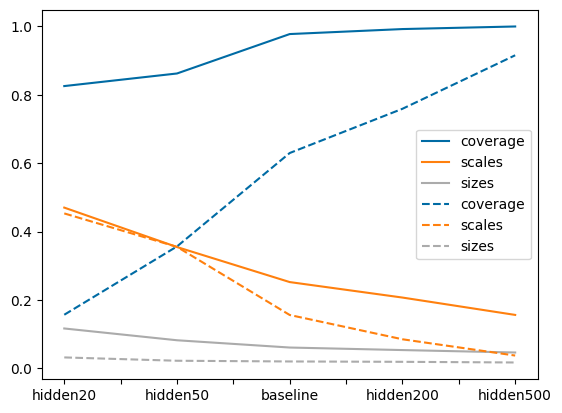

In [2]:
hiddens = [f'hidden{n}' for n in [20, 50, 200, 500]]
hiddens.insert(2, 'baseline')

ma = MultiAnalysis(data_path, hiddens)
xticks = [20, 50, 128, 200, 500]
xlabel = 'Hidden Layer Size'

ma.plot_coverage_stats()

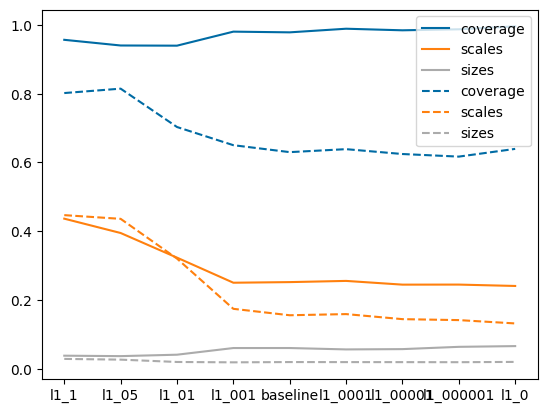

In [3]:
l1s = [f'l1_{n}' for n in ['1', '05', '01', '001', '0001', '00001', '000001', '0']]
l1s.insert(4, 'baseline')

ma = MultiAnalysis(data_path, l1s)
xticks = [1, 0.5, 0.1, 0.01, 0.005, 0.001, 0.0001, 0.00001, 0]
xlabel = 'Weight Regularizatin $\\lambda_{l1}$'

ma.plot_coverage_stats()

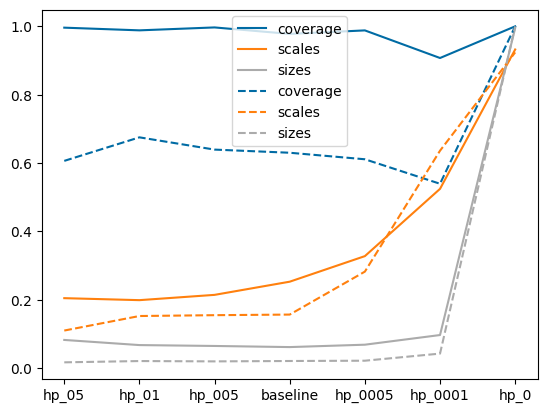

In [4]:
hps = [f'hp_{n}' for n in ['05', '01', '005', '0005', '0001', '0']]
hps.insert(3, 'baseline')

ma = MultiAnalysis(data_path, hps)
xticks = [0.5, 0.1, 0.05, 0.02, 0.005, 0.001, 0]
xlabel = 'Hidden Penalty $\\lambda_{hp}$'

ma.plot_coverage_stats()

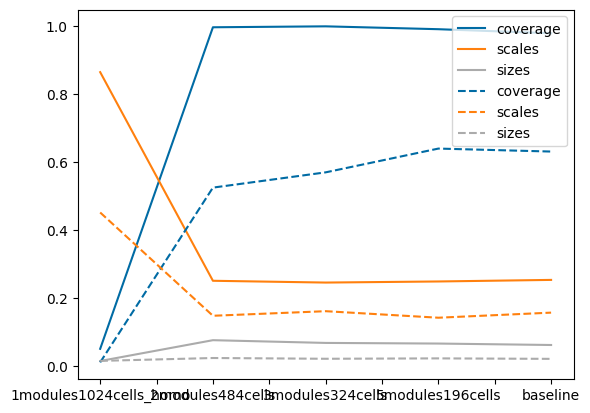

In [5]:
modules = ['1modules1024cells_homo', '2modules484cells', '3modules324cells', '5modules196cells', 'baseline']

ma = MultiAnalysis(data_path, modules)
xticks = [1, 2, 3, 5, 10]
xlabel = 'Number of Modules'

ma.plot_coverage_stats()

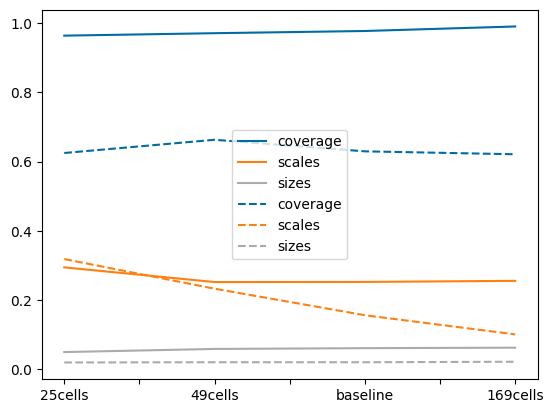

In [6]:
cells = ['25cells', '49cells', 'baseline', '169cells']

ma = MultiAnalysis(data_path, cells)
xticks = np.asarray([25, 49, 100, 169]) * 10
xlabel = 'Number of Grid Cells'

ma.plot_coverage_stats()

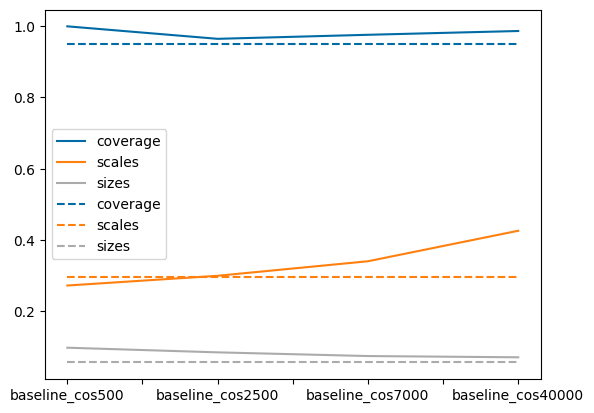

In [2]:
batches = [500, 2500, 7000, 40000]
hiddens = [f'baseline_cos{b}' for b in batches]

ma = MultiAnalysis(data_path, hiddens)
xticks = np.cumsum(batches)
xlabel = 'Batch'


ma.plot_coverage_stats()

### Useful Plot

In [7]:
exp = Experiment.load_experiment(data_path, 'baseline/0')

In [8]:
exp.compile_grid_cells(1)
exp.load_pfs()

In [9]:
coverage = exp.pfs.get_coverage()[exp.pfs.get_place_cells()].sum(0).cpu()
hiddens = exp.pfs.targets[exp.pfs.get_active_cells()].sum(0).cpu()

In [10]:
exp.compile_grid_cells(2)
exp.load_pfs()

In [11]:
coverage_remap = exp.pfs.get_coverage()[exp.pfs.get_place_cells()].sum(0).cpu()

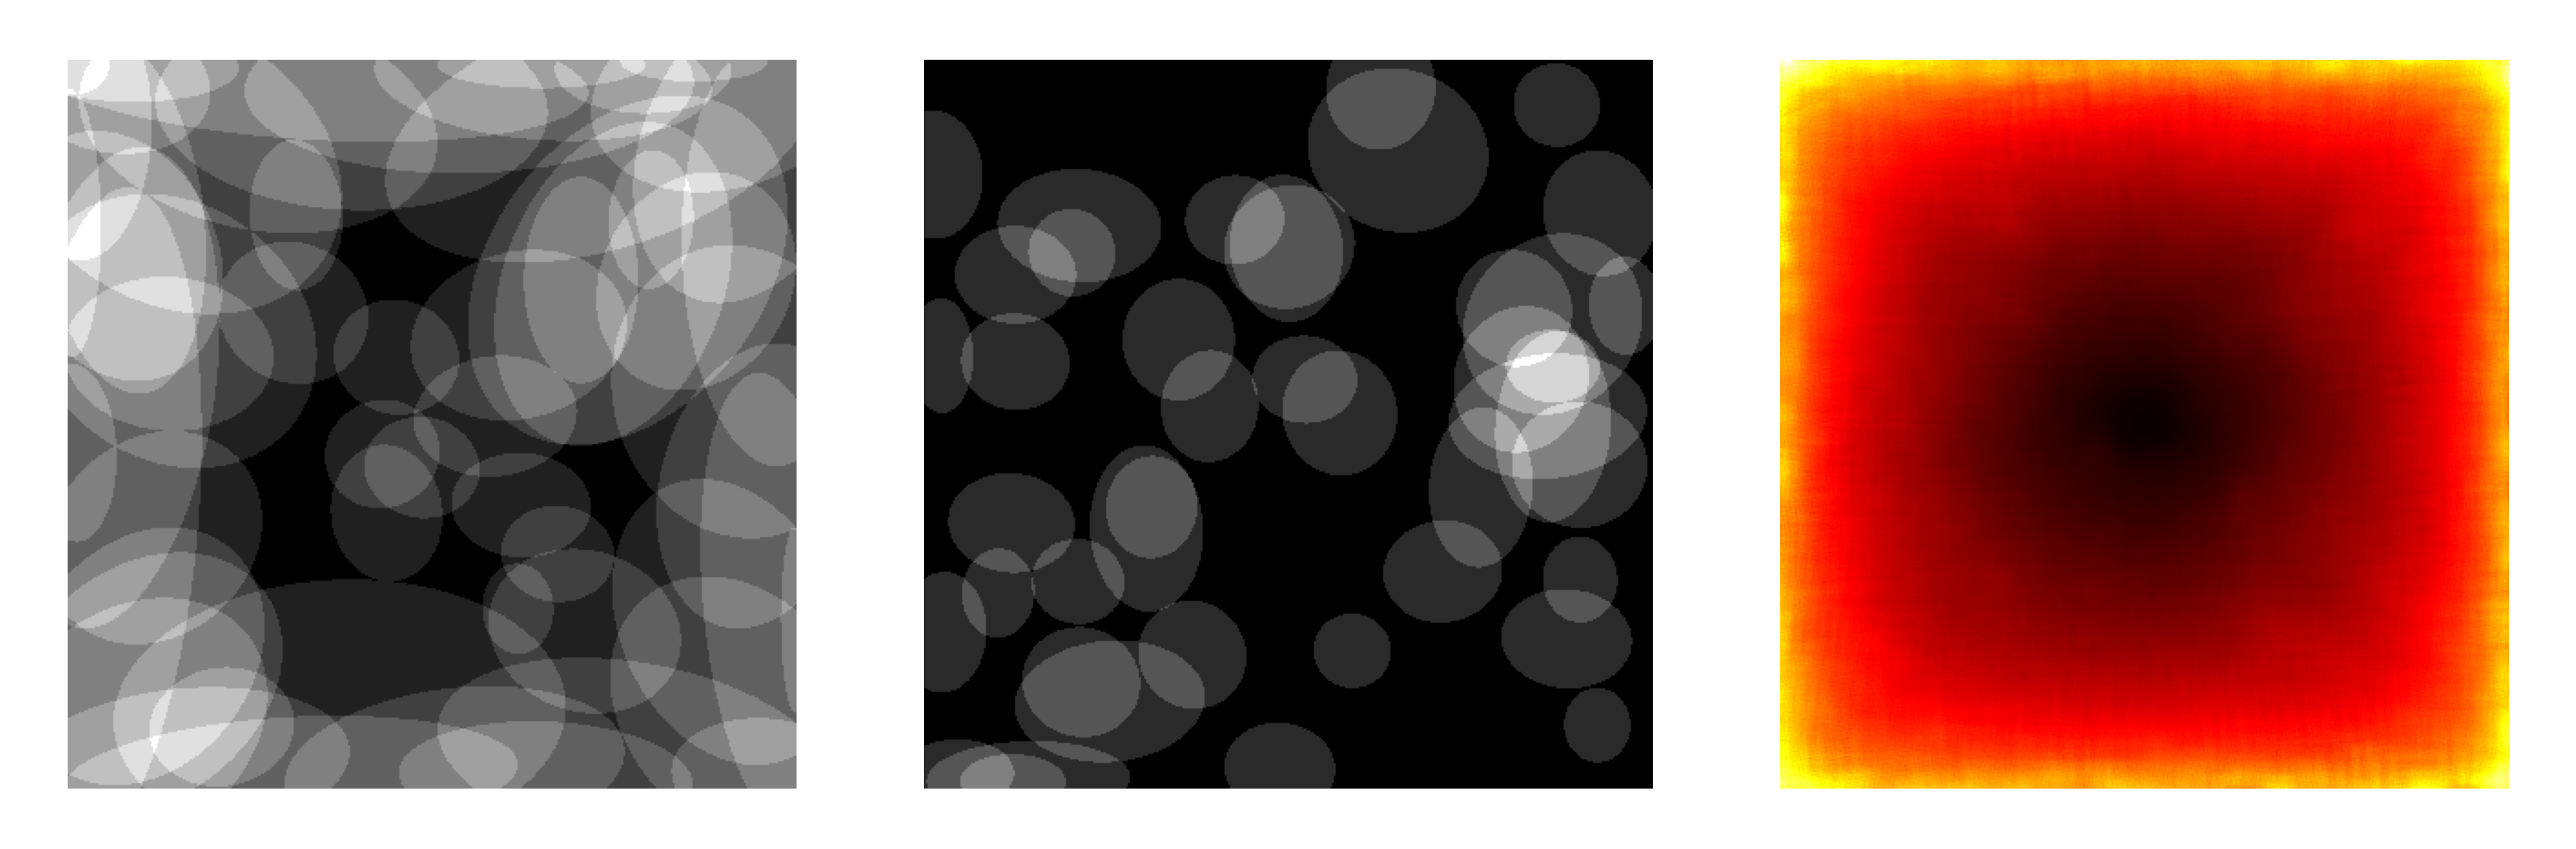

In [12]:
_, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 6), dpi=200)

ax1.imshow(coverage, cmap='gray')
ax1.axis('off')
ax1.axis('equal')

ax2.imshow(coverage_remap, cmap='gray')
ax2.axis('off')
ax2.axis('equal')

ax3.imshow(hiddens, cmap='hot')
ax3.axis('off')
ax3.axis('equal')

plt.tight_layout()
plt.savefig('../figs/coverage.png')
plt.show()

In [13]:
(exp.pfs.predict()[exp.pfs.get_place_cells()].sum(0) > 1-4).all()

tensor(True, device='cuda:0')

In [3]:
exp = Experiment.load_experiment(data_path, 'baseline_cos40000/0')

In [4]:
exp.compile_grid_cells(1)
exp.load_pfs()

In [5]:
coverage = exp.pfs.get_coverage()[exp.pfs.get_place_cells()].sum(0).cpu()
hiddens = exp.pfs.targets[exp.pfs.get_active_cells()].sum(0).cpu()

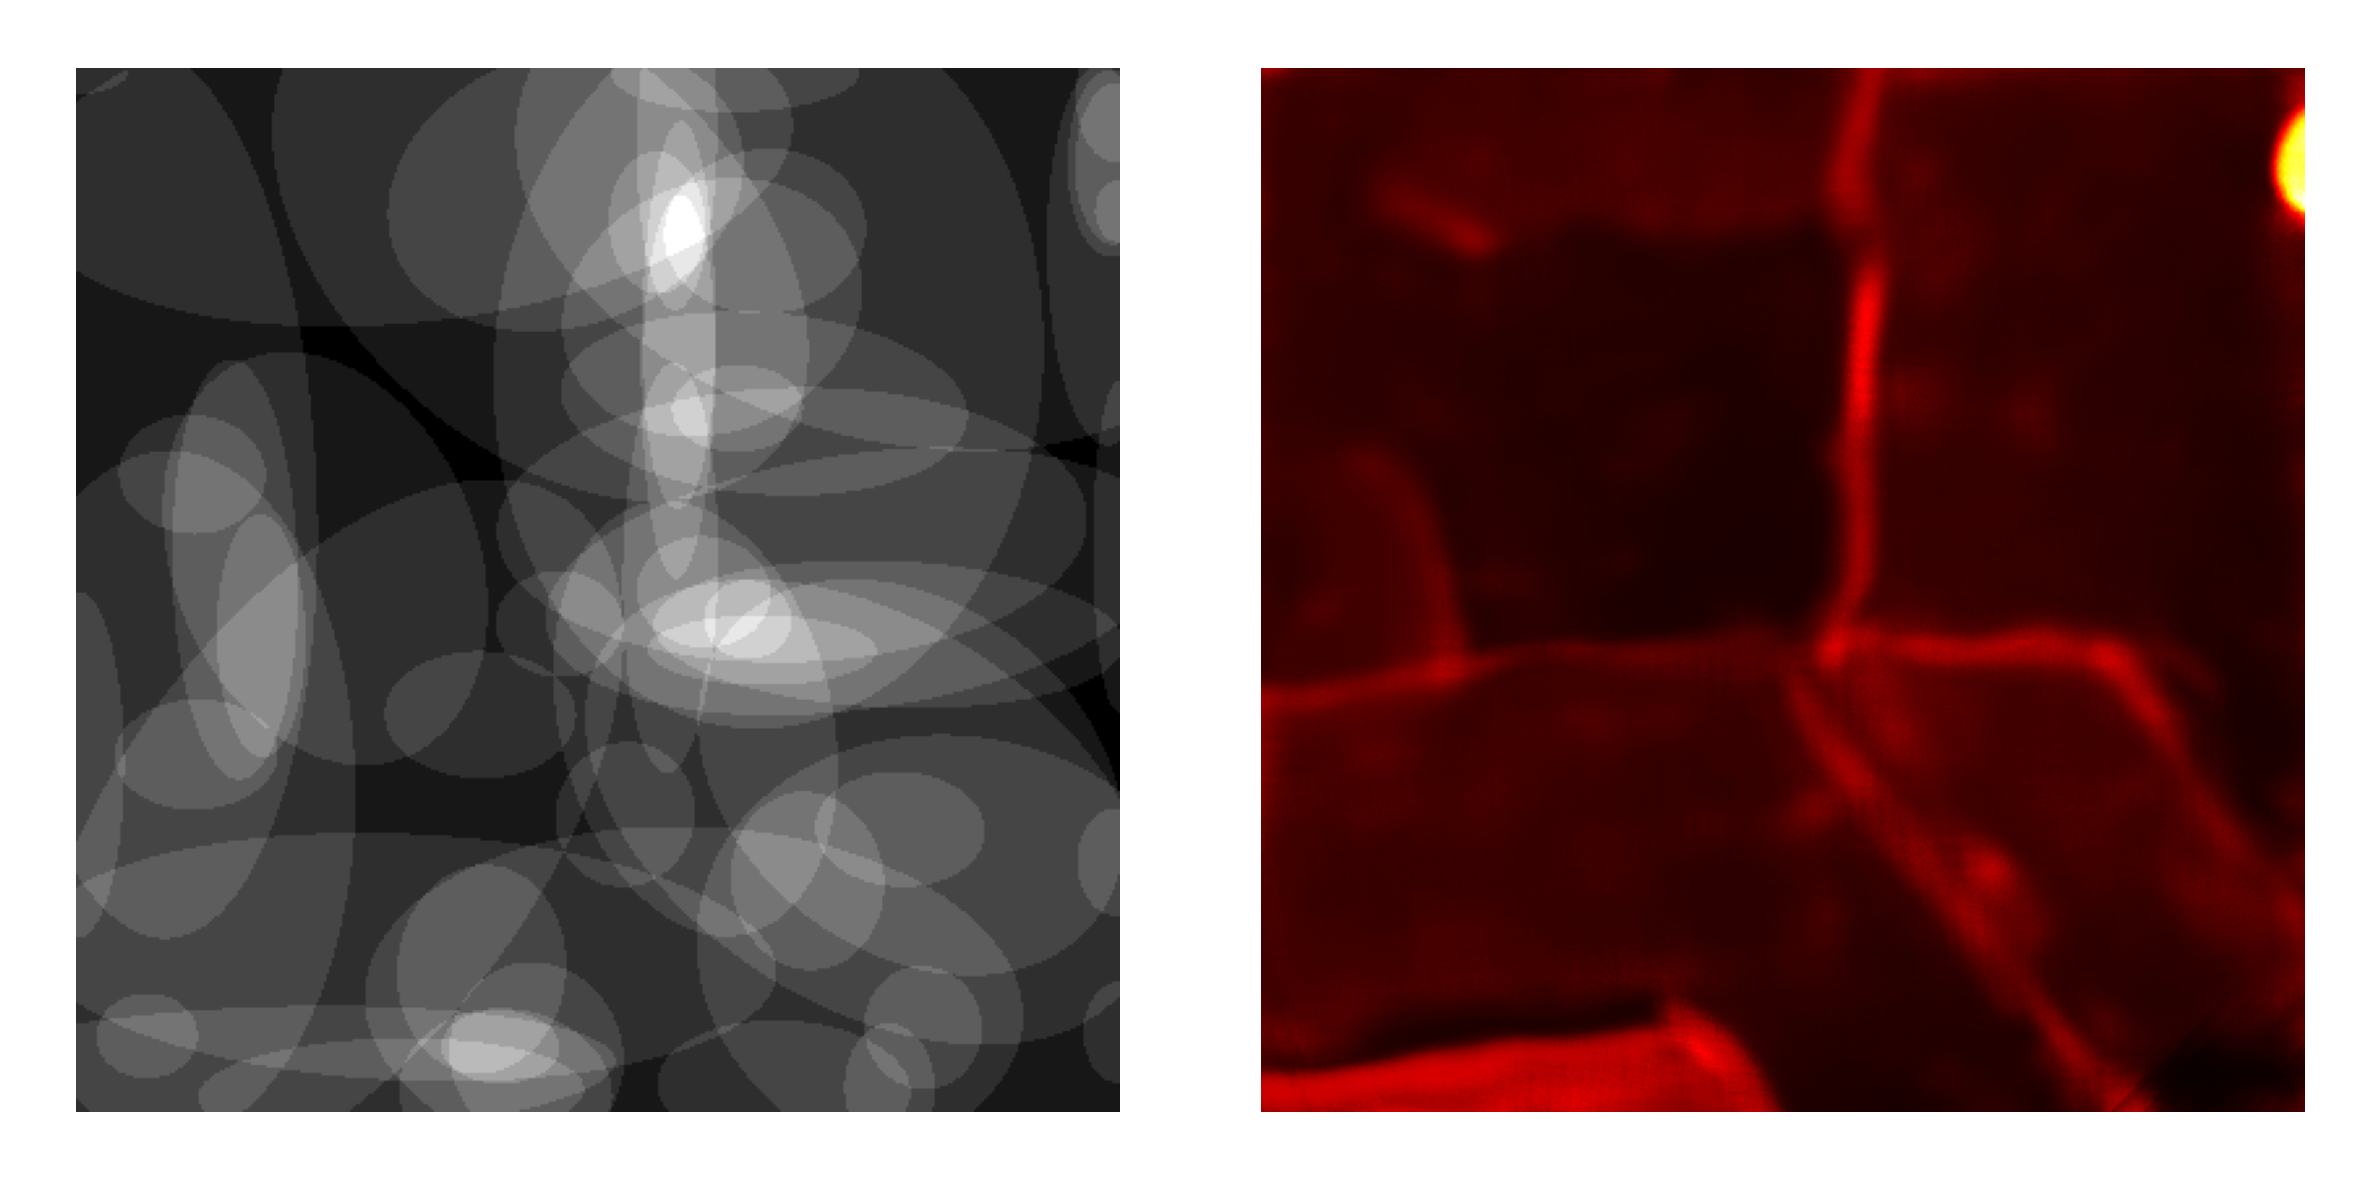

In [6]:
_, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6), dpi=200)

ax1.imshow(coverage, cmap='gray')
ax1.axis('off')
ax1.axis('equal')

ax2.imshow(hiddens, cmap='hot')
ax2.axis('off')
ax2.axis('equal')

plt.tight_layout()
plt.savefig('../figs/coverage2.png')
plt.show()

### Second Training

In [14]:
exp_names = ['2fits50b', '2fits500b', '2fits5000b', '2fits']
batches = [50, 500, 5000, 50000]

In [15]:
coverages = list()
pcs = list()
for name in exp_names:
    exp = Experiment.load_experiment(data_path, f"{name}/0_env2")
    anl = Analysis(exp, immediate_pc=True)
    coverages.append([exp.pfs_per_env[1].get_coverage().cpu(),
                      exp.pfs_per_env[2].get_coverage().cpu()])
    pcs.append([anl.place_cells_per_env[1], anl.place_cells_per_env[2]])
coverages = np.stack(coverages).transpose(1, 0, 2, 3, 4)

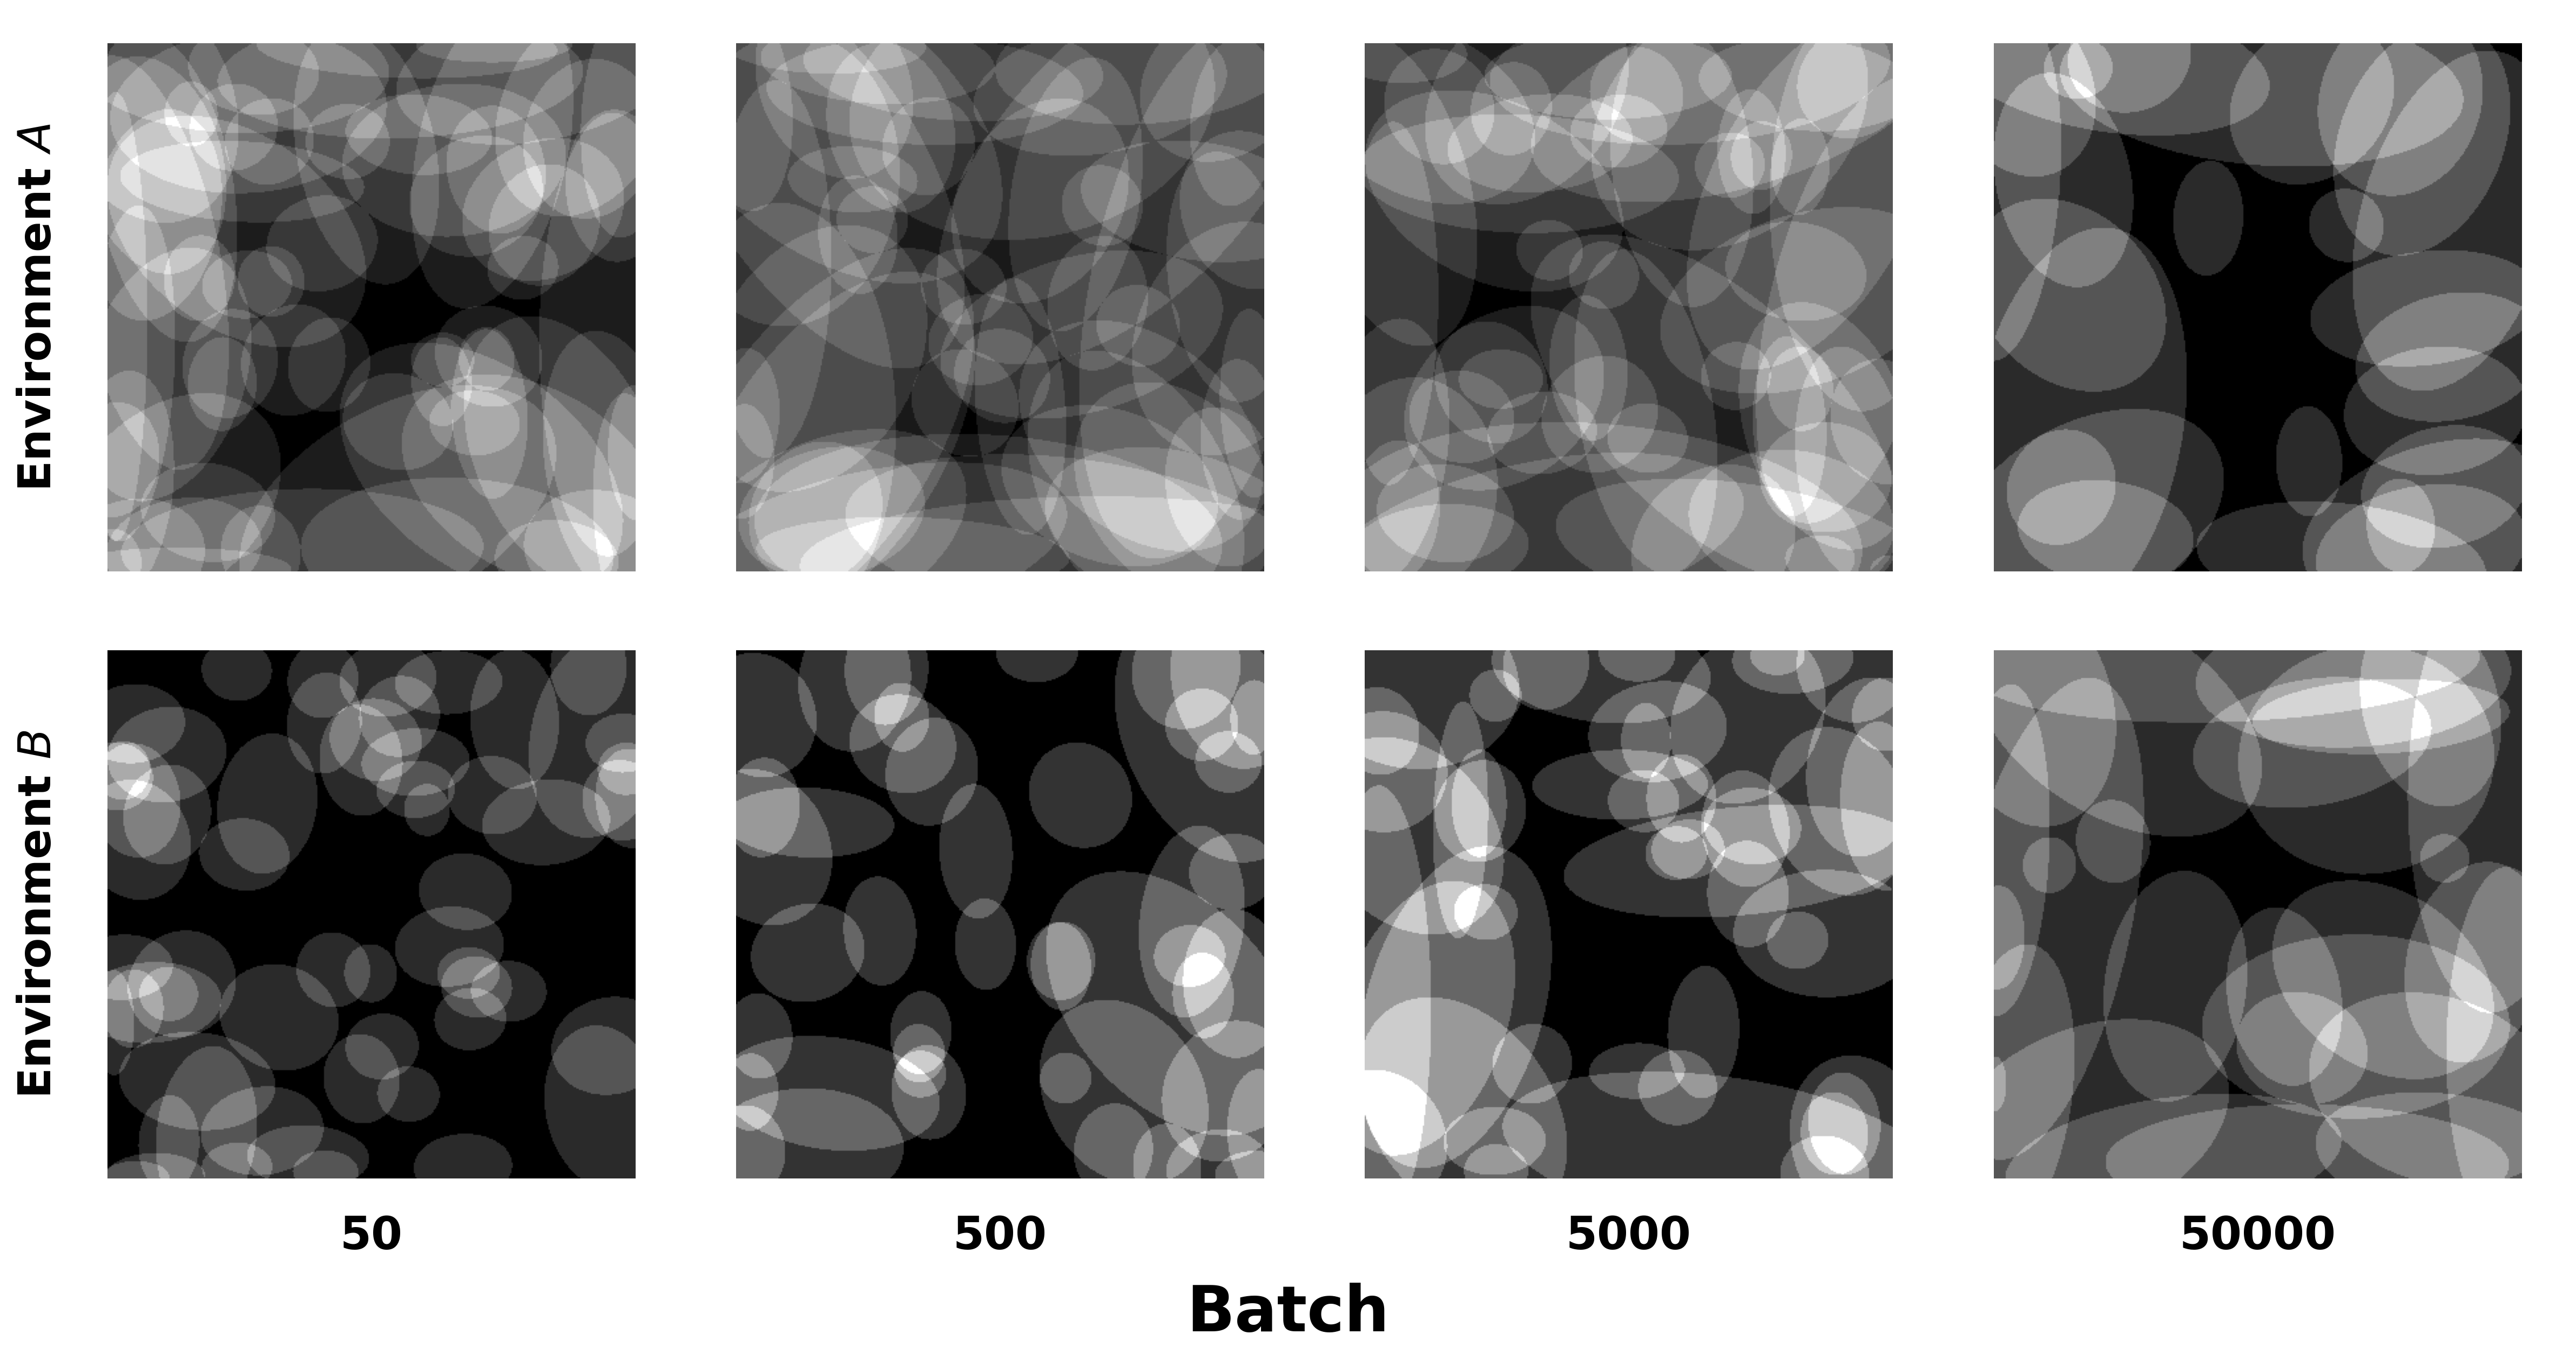

In [16]:
_, axs = plt.subplots(2, 4, figsize=(16, 8.5), dpi=300)

for axs_r, c_r, pc_r in zip(axs, coverages, [[pc[i] for pc in pcs] for i in range(2)]):
    for ax, c, pc in zip(axs_r, c_r, pc_r):
        ax.imshow(c[list(pc)].sum(0), cmap='gray')
        ax.axis('off')
        ax.axis('equal')

for i, env in zip(range(2), ['A', 'B']):
    axs[i, 0].axis('on')
    axs[i, 0].set_ylabel(f"Environment ${env}$", fontsize=20, fontweight='bold')
    axs[i, 0].get_yaxis().set_ticks([])
    axs[i, 0].get_xaxis().set_ticks([])
    for spine in axs[i, 0].spines.values():
        spine.set_visible(False)

for i, b in zip(range(4), batches):
    axs[1, i].axis('on')
    axs[1, i].set_xlabel(b, fontsize=20, fontweight='bold')
    axs[1, i].get_yaxis().set_ticks([])
    axs[1, i].get_xaxis().set_ticks([])
    for spine in axs[1, i].spines.values():
        spine.set_visible(False)

plt.suptitle("Batch", y=0, fontsize=28, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'coverage_env2.png'), bbox_inches='tight')
plt.show()